In [ ]:
import argparse
import time
import os
from random import sample

from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem import QED
from rdkit.Chem import AllChem
from rdkit import DataStructs

from scaffold_constrained_model import scaffold_constrained_RNN
from train_agent import train_agent
from data_structs import Vocabulary, Experience
from scoring_functions import get_scoring_function
from utils import Variable, seq_to_smiles, fraction_valid_smiles, unique
from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
import pandas as pd
import torch
 
# Loading trained model and appropriate vocabulary

voc = Vocabulary(init_from_file="data/DistributionLearningBenchmark/Voc")
    
Agent = scaffold_constrained_RNN(voc)
print(Agent.rnn.state_dict)
if torch.cuda.is_available():
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt'))
else:
    Agent.rnn.load_state_dict(torch.load('data/DistributionLearningBenchmark/Prior_ChEMBL_randomized.ckpt', map_location=lambda storage, loc: storage))


# 1. Distribution learning benchmarks

# Generating results

In [ ]:
#
# calculation of synthetic accessibility score as described in:
#
# Estimation of Synthetic Accessibility Score of Drug-like Molecules based on Molecular Complexity and Fragment Contributions
# Peter Ertl and Ansgar Schuffenhauer
# Journal of Cheminformatics 1:8 (2009)
# http://www.jcheminf.com/content/1/1/8
#
# several small modifications to the original paper are included
# particularly slightly different formula for marocyclic penalty
# and taking into account also molecule symmetry (fingerprint density)
#
# for a set of 10k diverse molecules the agreement between the original method
# as implemented in PipelinePilot and this implementation is r2 = 0.97
#
# peter ertl & greg landrum, september 2013
#


from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import pickle

import math
from collections import defaultdict

import os.path as op

_fscores = None


def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:

    data = pickle.load(gzip.open('fpscores.pkl.gz'))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict


def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro


def calculateScore(m):
    if _fscores is None:
        readFragmentScores()

    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                               2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf

    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1

    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    #  macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)

    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty

    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5

    sascore = score1 + score2 + score3

    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0

    return sascore


def processMols(mols):
    print('smiles\tName\tsa_score')
    for i, m in enumerate(mols):
        if m is None:
            continue

        s = calculateScore(m)

        smiles = Chem.MolToSmiles(m)
        print(smiles + "\t" + m.GetProp('_Name') + "\t%3f" % s)


#
#  Copyright (c) 2013, Novartis Institutes for BioMedical Research Inc.
#  All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#     * Redistributions in binary form must reproduce the above
#       copyright notice, this list of conditions and the following
#       disclaimer in the documentation and/or other materials provided
#       with the distribution.
#     * Neither the name of Novartis Institutes for BioMedical Research Inc.
#       nor the names of its contributors may be used to endorse or promote
#       products derived from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR
# A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT
# OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL,
# SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT
# LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE,
# DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY
# THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
# (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [22]:
def int_diversity(smiles):
    if len(smiles)==0:
        return 0.5
    diversity = 0
    for s in smiles:
        fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 4)
        for m in smiles:
            query_fp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(m), 4)
            diversity += DataStructs.TanimotoSimilarity(query_fp, fp) 
    diversity /= len(smiles)**2
    return 1 - diversity

def validity_and_uniqueness_assessement(pattern= "c1c(*)cc2c(c1)c(*)ccn2", refs = None, n_tryouts=5000, save_path=None):
    n_valid = 0
    n_unique = 0
    logP = []
    MW = []
    qed_list = []
    SAS = []
    HD_list = []
    HA_list = []
    smiles = []
        
    seqs, agent_likelihood, entropy = Agent.sample(pattern, batch_size=n_tryouts)
        #seqs, agent_likelihood, entropy = Agent.sample(1)
    for seq in seq_to_smiles(seqs, voc):
        mol = Chem.MolFromSmiles(seq)
    
        if mol:
            n_valid += 1

            if Chem.MolToSmiles(mol) not in smiles:
                smiles.append(Chem.MolToSmiles(mol))
                n_unique += 1
            try:
                MW.append(Descriptors.ExactMolWt(mol))
                logP.append(Descriptors.MolLogP(mol))
                qed_list.append(QED.qed(mol))
                SAS.append(calculateScore(mol))
                HA_list.append(Lipinski.NumHAcceptors(mol))
                HD_list.append(Lipinski.NumHDonors(mol))
            except:
                pass
    
    if save_path:
        
        df_summary = pd.DataFrame(columns = ["Scaffold", "Percentage valid molecules", "Percentage unique molecules"])
        df_summary["Scaffold"] = [pattern]
        df_summary["Percentage valid molecules"] = [n_valid/n_tryouts]
        df_summary["Percentage unique molecules"] = [n_unique/n_valid]

        df_details = pd.DataFrame(columns = ["Molecular weight",
                                    "Calculated log P", "Synthetizability Accessibility Score (SAS)", "Quantitative Estimate of Drug-likeness (QED)",
                                    "Number of H bonds acceptors", "Number of H bonds donors"])
        df_details["Molecular weight"] = MW
        df_details["Calculated log P"] = logP
        df_details["Synthetizability Accessibility Score (SAS)"] = SAS
        df_details["Quantitative Estimate of Drug-likeness (QED)"] = qed_list
        df_details["Number of H bonds acceptors"] = HA_list
        df_details["Number of H bonds donors"] = HD_list
        
        df_details.to_csv(save_path + "_details.csv")
        df_summary.to_csv(save_path + "_summary.csv")
    return n_valid/n_tryouts, n_unique/n_valid, MW, logP, SAS, qed_list, HA_list, HD_list

In [19]:
patterns = ['N(*)2C(=C)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C23CCC3',
 'C(*)N2CCN(C(=O)Oc3cncc(*)c3)C(C)C2',
 'c(*)1ccc(Nc2cnc(N)c(NCc3ccc4ncccc4c3)n2)nc1',
 'N(*)C(=O)C(=O)N2CCC(c3ccnc4ccc(*)cc34)CC2',
 'C(*)c1nc(=O)c(S(=O)(=O)c2ccc(*)c(*)c2)c(O)n1(*)',
 'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1',
 'C(*)Oc1cc(*)c(*)c(c2ccc3nc(N(*))ncc3c2)c1(*)',
 'c(*)1cnc2cc(*)c(*)cc2c1N1CCN(*)C(*)C1',
 'c1(*)cnc2cc(*)c(*)cc2c1N1CCNCC1',
 'C(*)NC2=NN=C(c3ccc4[nH]c(=O)[nH]c4c3)CS2',
 'C(*)#Cc1ccc(OCc2nnc(S(*))n2-c2cccnc2)cc1(*)',
 'C(*)C1=C(*)C(*)N=C(c2nccs2)N1',
 'S(*)(C)(=O)CC(c1ccc(OC)cc1)n1c(=O)n(*)c2cc(-c3ccccc3(*))ccc21',
 'c(*)1ccc2[nH]c3c(c2c1)CN(c1ccc2oc(N4CCOCC4)nc2c1)CC3',
 'c(*)1cc(Nc2ncc(*)c(Nc3ccccc3(*))n2)c(O(*))cc1C(*)',
 'C=C(*)C(=O)CC(=O)C=C(*)',
 'C(*)N(CC2=C(C(=O)OCC)C(c3ccc(F)cc3(*))N=C(c3nccs3)N2)']

drd2_patterns = ['c1(*)cccc2c1OCC(N(*)C(*))C2',
                 'O=C(*)NCC=CCN1CCN(*)CC1',
                 'C1(=O)N(*)CCN(*)1',
                 'O=C(NCC1N(*)CCC1)c1c(*)ccc(*)c1O(*)',
                 'O=C(NCCN1CCN(*)CC1)c1cc(Br)c2ccccc2c1(*)']

In [ ]:
for i, pattern in enumerate(patterns):
    val, uniques, mw, logp, synthetic_as, qeds, _, _ = validity_and_uniqueness_assessement(pattern, n_tryouts=10000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_surechembl')

for i, pattern in enumerate(drd2_patterns):
    val, uniques, mw, logp, synthetic_as, qeds, _, _ = validity_and_uniqueness_assessement(pattern, n_tryouts=10000, save_path='data/results_distribution_learning_benchmark/scaffold_'+str(i)+'_drd2')

1000 more...


/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/molecule_generation_develop/REINVENT/model.py:220: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(logits)
/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/molecule_generation_develop/REINVENT/model.py:221: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob = F.log_softmax(logits)
/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/molecule_generation_develop/REINVENT/model.py:432: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = F.softmax(logits)
/site/rp/work/projects/DD/Jupyter/notebooks/Maxime/molecule_generation_develop/REINVENT/model.py:433: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_prob 

1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
0.6330488750969744
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
0.7568652990339737
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
0.5429864253393665
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
0.7501070663811563
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
0.8093372510610513
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
0.8367346938775511
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
1000 more...
10

In [ ]:
validity = []
unicities = []
SAS = []
QEDs = []
MW = []
logP = []
HBA = []
HBD = []
scaffold = []
for i in range(17):
    df = pd.read_csv('data/results_distribution_learning_benchmark/scaffold_' + str(i) + '_surechembl_summary.csv')
    scaffold.append(df['Scaffold'][0])
    validity.append(df["Percentage valid molecules"][0])
    unicities.append(df["Percentage unique molecules"][0])
    df = pd.read_csv('data/results_distribution_learning_benchmark/scaffold_' + str(i) + '_surechembl_details.csv')
    SAS.extend(df["Synthetizability Accessibility Score (SAS)"])
    QEDs.extend(df["Quantitative Estimate of Drug-likeness (QED)"])
    MW.extend(df["Molecular weight"])
    logP.extend(df["Calculated log P"])
    HBA.extend(df["Number of H bonds acceptors"])
    HBD.extend(df["Number of H bonds donors"])


# Plotting validity and unicity

In [33]:
labels = [str(i+1) for i in range(len(validity))]

counts = []
for scaff in scaffold:
    counts.append(scaff.count('*'))
indexes = np.argsort(np.array(counts))

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(25,5))
rects1 = ax.bar(x - width/2, np.array(validity)[indexes], width, label='Validity')
rects2 = ax.bar(x + width/2, np.array(unicities)[indexes], width, label='Unicity')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validity and unicity proportion',fontsize=20)
ax.set_xlabel('Scaffold',fontsize=20)

ax.set_title('Validity and unicity proportion across 10000 molecules for each scaffold', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(prop={'size': 20})


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

plt.show()

/site/rp/work/projects/DD/Anaconda4AI/anaconda3/envs/torch_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


In [39]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=10)

ax.set_title('Validity across scaffolds (min, max, mean, and 95% CI)', fontsize=23)
ax.set_ylabel("Proportion of valid molecules",fontsize=23)
ax = sns.boxplot(x=validity, orient='v')
ax.set_ylim(0.5, 1)
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.show()

/site/rp/work/projects/DD/Anaconda4AI/anaconda3/envs/torch_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(w=10, h=10)

ax.set_title('Unicity across scaffolds (min, max, mean, and 95% CI)', fontsize=23)
ax.set_ylabel("Proportions of unique molecules", fontsize=20)
ax = sns.boxplot(x=unicities, orient='v')
ax.set_ylim(0.5, 1)
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.show()

/site/rp/work/projects/DD/Anaconda4AI/anaconda3/envs/torch_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


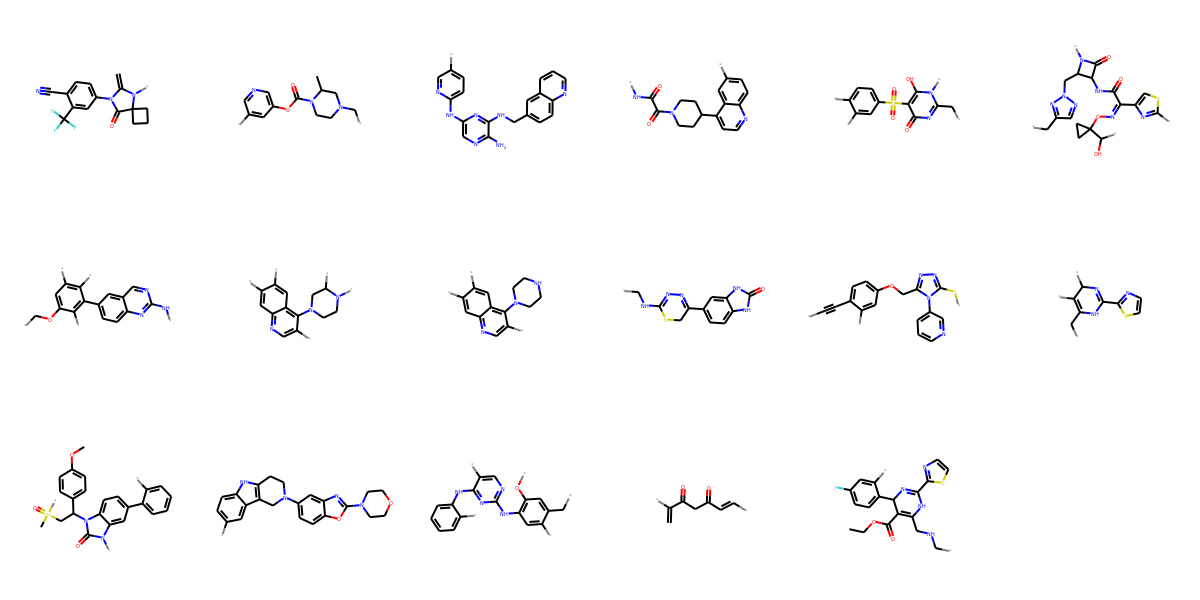

In [3]:
from rdkit.Chem import Draw
from rdkit import Chem

Draw.MolsToGridImage([Chem.MolFromSmiles(s) for s in ["N(*)2C(=C)N(c3ccc(C#N)c(C(F)(F)F)c3)C(=O)C23CCC3",
            'C(*)N2CCN(C(=O)Oc3cncc(*)c3)C(C)C2',
            'c(*)1ccc(Nc2cnc(N)c(NCc3ccc4ncccc4c3)n2)nc1',
            'N(*)C(=O)C(=O)N2CCC(c3ccnc4ccc(*)cc34)CC2',
            'C(*)c1nc(=O)c(S(=O)(=O)c2ccc(*)c(*)c2)c(O)n1(*)',
            'C(*)c1cnn(CC2C(NC(=O)C(=NOC3(C(*)O)CC3)c3csc(*)n3)C(=O)N2(*))n1',
            'C(*)Oc1cc(*)c(*)c(c2ccc3nc(N(*))ncc3c2)c1(*)', #6
            'c(*)1cnc2cc(*)c(*)cc2c1N1CCN(*)C(*)C1',
            'c1(*)cnc2cc(*)c(*)cc2c1N1CCNCC1',#8
            'C(*)NC2=NN=C(c3ccc4[nH]c(=O)[nH]c4c3)CS2', #10
            'C(*)#Cc1ccc(OCc2nnc(S(*))n2-c2cccnc2)cc1(*)',
            'C(*)C1=C(*)C(*)N=C(c2nccs2)N1',#12
            'S(*)(C)(=O)CC(c1ccc(OC)cc1)n1c(=O)n(*)c2cc(-c3ccccc3(*))ccc21',
            'c(*)1ccc2[nH]c3c(c2c1)CN(c1ccc2oc(N4CCOCC4)nc2c1)CC3',#14
            'c(*)1cc(Nc2ncc(*)c(Nc3ccccc3(*))n2)c(O(*))cc1C(*)',
            'C=C(*)C(=O)CC(=O)C=C(*)', #16
            'C(*)N(CC2=C(C(=O)OCC)C(c3ccc(F)cc3(*))N=C(c3nccs3)N2)']], molsPerRow=6)

# Plotting distributions

In [24]:
# Getting molecules from SureChEMBL ("validation set" in the paper)
suppl = Chem.SDMolSupplier('data/SureChEMBL/200323_SureChemBL_dataset_636.sdf')
smiles = []
series = []
comparisons = []
for i, mol in enumerate(suppl):
    series.append(mol.GetProp('Series_Name'))
    smiles.append(Chem.MolToSmiles(mol))
    comparisons.append(mol)
    
logP_Chembl_original = []
MW_Chembl_original = []
qed_list_Chembl_original = []
SAS_Chembl_original = []
HBA_ChEMBL_original = []
HBD_ChEMBL_original = []
for mol in comparisons:            
    MW_Chembl_original.append(Descriptors.ExactMolWt(mol))
    logP_Chembl_original.append(Descriptors.MolLogP(mol))
    qed_list_Chembl_original.append(QED.qed(mol))
    SAS_Chembl_original.append(calculateScore(mol))
    HBA_ChEMBL_original.append(Lipinski.NumHAcceptors(mol))
    HBD_ChEMBL_original.append(Lipinski.NumHDonors(mol))

In [25]:
# Getting a subset from ChEMBL ("training set" in the paper)
suppl = Chem.SmilesMolSupplier('data/ChEMBL_filtered',delimiter='\t',titleLine=False)
count = 0
comparisons_chembl = []
for mol in suppl:
    comparisons.append(mol)
    count += 1
    if count>10000:
        break

    
logP_Chembl = []
MW_Chembl = []
qed_list_Chembl = []
SAS_Chembl = []
HBA_ChEMBL = []
HBD_ChEMBL = []
for mol in comparisons:            
    MW_Chembl.append(Descriptors.ExactMolWt(mol))
    logP_Chembl.append(Descriptors.MolLogP(mol))
    qed_list_Chembl.append(QED.qed(mol))
    SAS_Chembl.append(calculateScore(mol))
    HBA_ChEMBL.append(Lipinski.NumHAcceptors(mol))
    HBD_ChEMBL.append(Lipinski.NumHDonors(mol))

RDKit WARNING: [15:30:11] WARNING: no name column found on line 0
RDKit WARNING: [15:30:11] WARNING: no name column found on line 1
RDKit WARNING: [15:30:11] WARNING: no name column found on line 2
RDKit WARNING: [15:30:11] WARNING: no name column found on line 3
RDKit WARNING: [15:30:11] WARNING: no name column found on line 4
RDKit WARNING: [15:30:11] WARNING: no name column found on line 5
RDKit WARNING: [15:30:11] WARNING: no name column found on line 6
RDKit WARNING: [15:30:11] WARNING: no name column found on line 7
RDKit WARNING: [15:30:11] WARNING: no name column found on line 8
RDKit WARNING: [15:30:11] WARNING: no name column found on line 9
RDKit WARNING: [15:30:11] WARNING: no name column found on line 10
RDKit WARNING: [15:30:11] WARNING: no name column found on line 11
RDKit WARNING: [15:30:11] WARNING: no name column found on line 12
RDKit WARNING: [15:30:11] WARNING: no name column found on line 13
RDKit WARNING: [15:30:11] WARNING: no name column found on line 14
RDKit

RDKit WARNING: [15:30:12] WARNING: no name column found on line 2064
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2065
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2066
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2067
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2068
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2069
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2070
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2071
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2072
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2073
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2074
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2075
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2076
RDKit WARNING: [15:30:12] WARNING: no name column found on line 2077
RDKit WARNING: [15:30:12] WARNING:

RDKit WARNING: [15:30:13] WARNING: no name column found on line 3063
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3064
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3065
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3066
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3067
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3068
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3069
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3070
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3071
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3072
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3073
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3074
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3075
RDKit WARNING: [15:30:13] WARNING: no name column found on line 3076
RDKit WARNING: [15:30:13] WARNING:

RDKit WARNING: [15:30:13] WARNING: no name column found on line 4062
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4063
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4064
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4065
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4066
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4067
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4068
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4069
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4070
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4071
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4072
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4073
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4074
RDKit WARNING: [15:30:13] WARNING: no name column found on line 4075
RDKit WARNING: [15:30:13] WARNING:

RDKit WARNING: [15:30:13] WARNING: no name column found on line 5061
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5062
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5063
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5064
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5065
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5066
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5067
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5068
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5069
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5070
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5071
RDKit WARNING: [15:30:13] WARNING: no name column found on line 5072
RDKit WARNING: [15:30:14] WARNING: no name column found on line 5073
RDKit WARNING: [15:30:14] WARNING: no name column found on line 5074
RDKit WARNING: [15:30:14] WARNING:

RDKit WARNING: [15:30:14] WARNING: no name column found on line 6060
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6061
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6062
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6063
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6064
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6065
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6066
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6067
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6068
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6069
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6070
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6071
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6072
RDKit WARNING: [15:30:14] WARNING: no name column found on line 6073
RDKit WARNING: [15:30:14] WARNING:

RDKit WARNING: [15:30:15] WARNING: no name column found on line 8059
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8060
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8061
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8062
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8063
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8064
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8065
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8066
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8067
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8068
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8069
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8070
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8071
RDKit WARNING: [15:30:15] WARNING: no name column found on line 8072
RDKit WARNING: [15:30:15] WARNING:

RDKit WARNING: [15:30:15] WARNING: no name column found on line 9058
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9059
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9060
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9061
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9062
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9063
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9064
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9065
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9066
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9067
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9068
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9069
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9070
RDKit WARNING: [15:30:15] WARNING: no name column found on line 9071
RDKit WARNING: [15:30:15] WARNING:

In [43]:
sns.set()
plt.figure(figsize=(15, 15))

plt.subplot(231)
plt.hist([MW, MW_Chembl_original, MW_Chembl], weights=[np.ones(len(MW)) / len(MW),
                                                       np.ones(len(MW_Chembl_original)) / len(MW_Chembl_original),
                                                       np.ones(len(MW_Chembl)) / len(MW_Chembl),], range= (0,1500), label=['Generic RNN', 'Validation set', 'Training set'])
plt.legend(loc=1, prop={'size': 20})

plt.ylabel('Proportion of molecules', fontsize=18)
plt.xlabel('Molecular Weight', fontsize=16)

plt.subplot(232)
plt.hist([logP, logP_Chembl, logP_Chembl_original], weights=[np.ones(len(logP)) / len(logP),
                                                       np.ones(len(logP_Chembl)) / len(logP_Chembl),
                                                       np.ones(len(logP_Chembl_original)) / len(logP_Chembl_original),], range= (-7,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.xlabel('Calculated log P', fontsize=16)


plt.subplot(233)
plt.hist([HBA, HBA_ChEMBL_original, HBA_ChEMBL], weights=[np.ones(len(HBA)) / len(HBA),
                                                       np.ones(len(HBA_ChEMBL_original)) / len(HBA_ChEMBL_original),
                                                       np.ones(len(HBA_ChEMBL)) / len(HBA_ChEMBL),], range= (0,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.xlabel('Hydrogen Bonds Acceptors (HBA)', fontsize=16)

plt.subplot(234)
plt.hist([HBD, HBD_ChEMBL_original, HBD_ChEMBL], weights=[np.ones(len(HBD)) / len(HBD),
                                                       np.ones(len(HBD_ChEMBL_original)) / len(HBD_ChEMBL_original),
                                                       np.ones(len(HBD_ChEMBL)) / len(HBD_ChEMBL),], range= (0,10), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.ylabel('Proportion of molecules', fontsize=18)
plt.xlabel('Hydrogen Bonds Donors (HBD)', fontsize=16)

plt.subplot(235)
plt.hist([SAS, SAS_Chembl_original, SAS_Chembl], weights=[np.ones(len(SAS)) / len(SAS),
                                                       np.ones(len(SAS_Chembl_original)) / len(SAS_Chembl_original),
                                                       np.ones(len(SAS_Chembl)) / len(SAS_Chembl),], range= (2,8), label=['Generated molecules', 'SureChEMBL molecules', 'ChEMBL molecules'])
plt.xlabel('Synthetizability Accessibility Score (SAS)', fontsize=16)

plt.subplot(236)
plt.hist([QEDs, qed_list_Chembl_original, qed_list_Chembl], weights=[np.ones(len(QEDs)) / len(QEDs),
                                                       np.ones(len(qed_list_Chembl_original)) / len(qed_list_Chembl_original),
                                                       np.ones(len(qed_list_Chembl)) / len(qed_list_Chembl),], range= (0,1), label=['Generic RNN', 'Validation set', 'Training set'])

plt.xlabel('Quantitative Estimate of Drug-likeness (QED)', fontsize=16)



    
plt.show()

/site/rp/work/projects/DD/Anaconda4AI/anaconda3/envs/torch_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
